In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils as vutils
from torch import nn, optim
import cv2
import matplotlib.pyplot as plt
import glob
import random
from copy import deepcopy
import numpy as np
import sys
sys.path.append('../')
from src.embedders.base_embedder import BaseEmbedder
from src.metrics.cosine_similarity import CosineSimilarity
from src.metrics.mahalanobis import MahalanobisDistance
from src.metrics.euclidian import EuclideanDistance

Total 1824 images, 228 classes


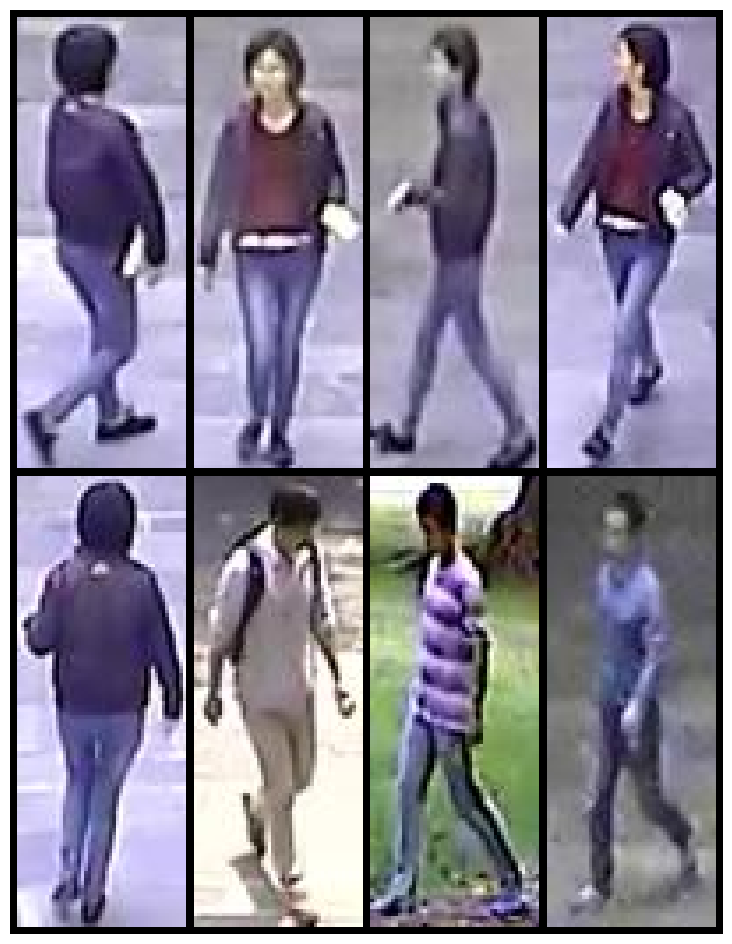

In [26]:
class FewshotPersonBiasingDataset:
    def __init__(self, data_path: str, k: int = 6) -> None:
        self.data_path = data_path
        self.k = k
        self.dataset = self._load_data()
        self.keys = list(self.dataset.keys())

    def _load_data(self):
        dataset_map = {}
        num_img = 0
        for filename in glob.glob(self.data_path + '/*.png'):
            img = torchvision.io.read_image(filename)
            img = img.float() / 255.0
            label = '_'.join(filename.split('/')[-1].split('_')[0:2])
            num_img += 1 
            if label not in dataset_map:
                dataset_map[label] = []
            dataset_map[label].append(img)
        print(f"Total {num_img} images, {len(dataset_map)} classes")
        return dataset_map
    def gen_task(self):
        target_class = random.choice(self.keys)
        shuffled = self.dataset[target_class].copy()
        target, target_query = shuffled[:self.k], shuffled[self.k: self.k + 1]
        non_target_classes = []
        non_target_query = []
        while len(non_target_classes) < self.k - 1:
            c = random.choice(self.keys)
            if c != target_class and c not in non_target_classes:
                non_target_classes.append(c)
        for c in non_target_classes:
            non_target_query.append(random.choice(self.dataset[c]))
        target = torch.stack(target, dim=0)
        target_query = torch.stack(target_query, dim=0)
        non_target_query = torch.stack(non_target_query, dim=0)
        labels = torch.tensor([1, -1, -1, -1], dtype=torch.float32)
        return target, torch.concat([target_query, non_target_query], dim=0), labels
    
    def show_task(self, target, query, labels):
        grid = vutils.make_grid(torch.cat([target, query], dim=0), nrow=self.k, padding=2, normalize=True)
        plt.figure(figsize=(12,12))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

    def show_example(self, classes: list[int] | None = None):
        if classes is None:
            classes = random.choices(self.keys, k=4)
        classes_images = []
        for c in classes:
            a = torch.stack(self.dataset[c], dim=0)
            classes_images.append(a)
        classes_images = torch.cat(classes_images, dim=0)
        grid = vutils.make_grid(classes_images, nrow=8, padding=2, normalize=True)
        plt.figure(figsize=(12,12))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
data_path = FewshotPersonBiasingDataset('../datasets/PKUv1a_128x48', k=4)
data_path.show_task(*data_path.gen_task())
# data_path.show_example()

In [27]:
class FewShotBiasor(nn.Module):
      def __init__(self) -> None:
          super().__init__()
          self.biasor = nn.Sequential(
               nn.Linear(512, 512),
               nn.ReLU(),
                nn.Linear(512, 512),
          )
          self.device = "cuda" if torch.cuda.is_available() else "cpu"
          self.embedder = BaseEmbedder().model
          self.embedder.eval()
          self.embedder.to(self.device)
          self.biasor.to(self.device)
          self.optimizer = optim.Adam(self.biasor.parameters(), lr=1e-3)
          self.mse = nn.MSELoss()
          self._losses = []
          self._step = 0
      def forward(self, x):
        return self.biasor(x) 
      
      def biasing(self, target_features, query_features, labels):
            target = target_features.to(self.device)
            query = query_features.to(self.device)
            labels = labels.to(self.device)

            biased_target = self.biasor(target)
            biased_query = self.biasor(query)

            # compute mean cosine similarity between biased target and biased query
            mean_cos_sim = torch.zeros(query.size(0), device=self.device)
            for i in range(target.size(0)):
                  mean_cos_sim += torch.cosine_similarity(biased_target[i].unsqueeze(0), biased_query, dim=1)
            mean_cos_sim /= target.size(0)
            print(mean_cos_sim)

            # compute mse loss
            loss = self.mse(mean_cos_sim, labels)
            loss.backward(retain_graph=True)
            self.optimizer.step()
            self.optimizer.zero_grad()
            self._losses.append(loss.item())
            self._step += 1
      
      def train_step(self, target_features, query_features, labels):
            target = target_features.to(self.device)
            query = query_features.to(self.device)
            labels = labels.to(self.device)

            biased_target = self.biasor(target)
            biased_query = self.biasor(query)

            # compute mean cosine similarity between biased target and biased query
            mean_cos_sim = torch.zeros(query.size(0), device=self.device)
            for i in range(target.size(0)):
                  mean_cos_sim += torch.cosine_similarity(biased_target[i].unsqueeze(0), biased_query, dim=1)
            mean_cos_sim /= target.size(0)
            print(mean_cos_sim)

            # compute mse loss
            loss = self.mse(mean_cos_sim, labels)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            self._losses.append(loss.item())
            self._step += 1
      def show_progress(self):
            plt.figure(figsize=(12, 8))
            plt.plot(self._losses, label='loss')
            plt.legend()
            plt.show()


biasor = FewShotBiasor()
mse = nn.MSELoss()

Successfully loaded imagenet pretrained weights from "/home/nhuengzii/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"


tensor([0.7331, 0.6377, 0.6424, 0.6782], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.4829, -0.1087, -0.0929,  0.0127], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.6512, -0.4788, -0.3975, -0.4020], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.8274, -0.6301, -0.5684, -0.6036], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.9055, -0.7359, -0.6975, -0.7354], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([0.4706, 0.4071, 0.3992, 0.4334], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.3182,  0.0228, -0.0225,  0.0544], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.4220, -0.2179, -0.3384, -0.2040], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.6443, -0.3205, -0.4476, -0.2968], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([ 0.7793, -0.4696, -0.5556, -0.4351], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([0.3484, 0.2546, 0.1871, 0.2242], device='cuda:0',
       grad_fn=<DivB

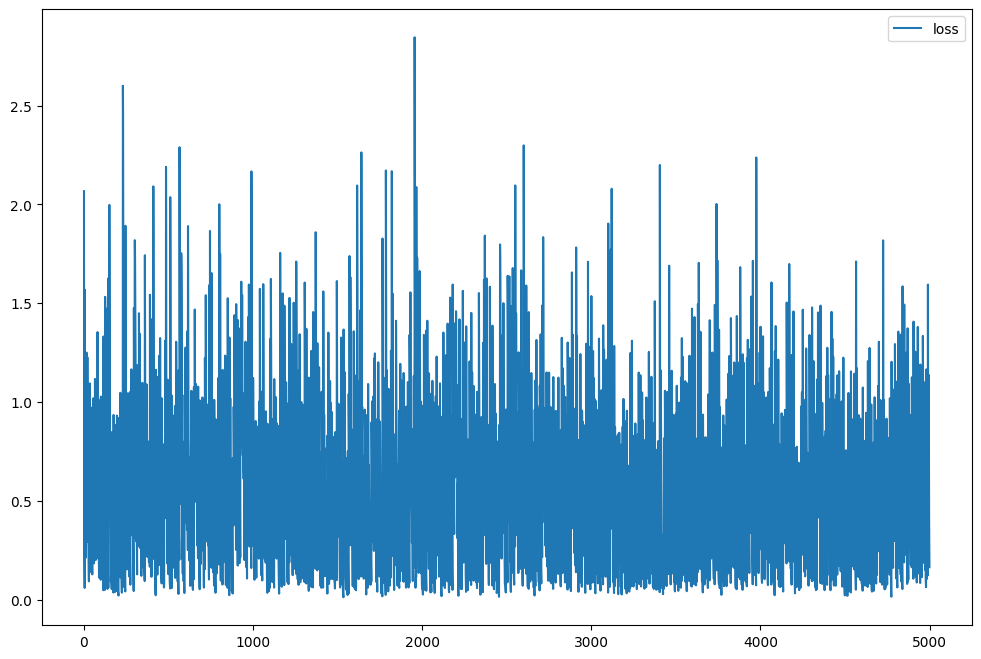

In [28]:
# Training loop
meta_iters = 1000
meta_step_size = 0.25
inner_iters = 5
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    current_weights = deepcopy(biasor.biasor.state_dict())

    # Train the model on the current task
    target, query, labels = data_path.gen_task()
    with torch.no_grad():
        target_features = biasor.embedder(target.to(biasor.device))
        query_features = biasor.embedder(query.to(biasor.device))
    
    for inner_iter in range(inner_iters):
        biasor.train_step(target_features, query_features, labels)
    
    new_weights = biasor.biasor.state_dict()
    state_dict = {candidate: (current_weights[candidate] + (new_weights[candidate] - current_weights[candidate]) * cur_meta_step_size) for candidate in new_weights}

    biasor.biasor.load_state_dict(state_dict)

print("Done training")
biasor.show_progress()

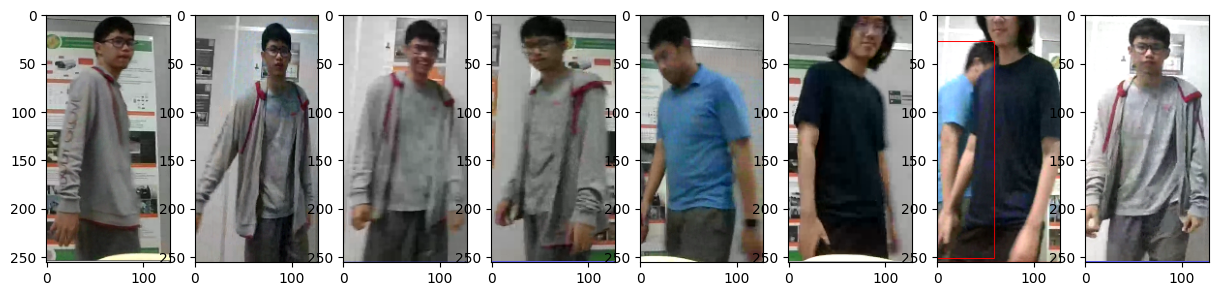

In [29]:

target = cv2.imread('../validates/validate_sets/set1/target_images/target.png')
target1 = cv2.imread('../validates/validate_sets/set1/target_images/target1.png')
target2 = cv2.imread('../validates/validate_sets/set1/target_images/target2.png')
target3 = cv2.imread('../validates/validate_sets/set1/target_images/target3.png')
non_target = cv2.imread('../non_target.png')
non_target1 = cv2.imread('../non_target1.png')
non_target2 = cv2.imread('../non_target2.png')
non_target3 = cv2.imread('../non_target3.png')

target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
target = cv2.resize(target, (128, 256))
target1 = cv2.cvtColor(target1, cv2.COLOR_BGR2RGB)
target1 = cv2.resize(target1, (128, 256))
target2 = cv2.cvtColor(target2, cv2.COLOR_BGR2RGB)
target2 = cv2.resize(target2, (128, 256))
target3 = cv2.cvtColor(target3, cv2.COLOR_BGR2RGB)
target3 = cv2.resize(target3, (128, 256))
non_target = cv2.cvtColor(non_target, cv2.COLOR_BGR2RGB)
non_target = cv2.resize(non_target, (128, 256))
non_target1 = cv2.cvtColor(non_target1, cv2.COLOR_BGR2RGB)
non_target1 = cv2.resize(non_target1, (128, 256))
non_target2 = cv2.cvtColor(non_target2, cv2.COLOR_BGR2RGB)
non_target2 = cv2.resize(non_target2, (128, 256))
non_target3 = cv2.cvtColor(non_target3, cv2.COLOR_BGR2RGB)
non_target3 = cv2.resize(non_target3, (128, 256))

target = torch.from_numpy(target).permute(2, 0, 1).unsqueeze(0).float()
target1 = torch.from_numpy(target1).permute(2, 0, 1).unsqueeze(0).float()
target2 = torch.from_numpy(target2).permute(2, 0, 1).unsqueeze(0).float()
target3 = torch.from_numpy(target3).permute(2, 0, 1).unsqueeze(0).float()
non_target = torch.from_numpy(non_target).permute(2, 0, 1).unsqueeze(0).float()
non_target1 = torch.from_numpy(non_target1).permute(2, 0, 1).unsqueeze(0).float()
non_target2 = torch.from_numpy(non_target2).permute(2, 0, 1).unsqueeze(0).float()
non_target3 = torch.from_numpy(non_target3).permute(2, 0, 1).unsqueeze(0).float()
num_target = 8
plt.subplots(1, num_target, figsize=(15, 15))
plt.subplot(1, num_target, 1)
plt.imshow(target.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.subplot(1,num_target, 2)
plt.imshow(target1.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.subplot(1, num_target, 3)
plt.imshow(target2.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.subplot(1, num_target, 4)
plt.imshow(target3.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.subplot(1, num_target, 5)
plt.imshow(non_target.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.subplot(1, num_target, 6)
plt.imshow(non_target1.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.subplot(1, num_target, 7)
plt.imshow(non_target2.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.subplot(1, num_target, 8)
plt.imshow(non_target3.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
plt.show()

In [ ]:
embedder = BaseEmbedder().model
target_feature = embedder(target)
target1_feature = embedder(target1)
target2_feature = embedder(target2)
target3_feature = embedder(target3)
non_target_feature = embedder(non_target)
non_target1_feature = embedder(non_target1)
non_target2_feature = embedder(non_target2)
non_target3_feature = embedder(non_target3)

Successfully loaded imagenet pretrained weights from "/home/nhuengzii/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"


In [42]:
met_ma = MahalanobisDistance()
met_co = CosineSimilarity()
t = torch.cat([target_feature, target1_feature], dim=0).squeeze(1)
q = torch.cat([target3_feature, non_target3_feature], dim=0).squeeze(1)
ma_dist = met_ma.compute_distances(t, q)
co_sim = met_co.compute_similarity(t, q)
print(ma_dist)
print(co_sim)

tensor([[4366.8130, 4366.8130],
        [4178.2681, 4178.2681]])
tensor([[0.7794, 0.6837],
        [0.6776, 0.7553]])


In [ ]:
t = torch.stack([target_feature, target1_feature, target2_feature, target3_feature], dim=0).squeeze(1)
q = torch.stack([non_target_feature, non_target1_feature, non_target2_feature, non_target3_feature], dim=0).squeeze(1)
labels = torch.tensor([-1, -1, -1, 1], dtype=torch.float32)
print(t.shape, q.shape, labels.shape)
for i in range(5):
    biasor.biasing(t, q, labels)

torch.Size([4, 512]) torch.Size([4, 512]) torch.Size([4])
tensor([-0.0878, -0.2192,  0.0141,  0.8902], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([-0.5258, -0.6673, -0.4441,  0.8697], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([-0.4100, -0.5532, -0.6184,  0.9000], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([-0.4699, -0.5528, -0.6881,  0.9180], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([-0.6054, -0.6735, -0.7506,  0.9384], device='cuda:0',
       grad_fn=<DivBackward0>)


In [ ]:
biasor.eval().cpu()
biased_target_feature = biasor(target_feature)
biased_target1_feature = biasor(target1_feature)
biased_target2_feature = biasor(target2_feature)
biased_target3_feature = biasor(target3_feature)
biased_non_target_feature = biasor(non_target_feature)
biased_non_target1_feature = biasor(non_target1_feature)
biased_non_target2_feature = biasor(non_target2_feature)
biased_non_target3_feature = biasor(non_target3_feature)


In [ ]:
mat_cosine = CosineSimilarity()
mat_mahalanobis = MahalanobisDistance()

target_features = torch.stack([biased_target_feature, biased_target1_feature, biased_target2_feature, biased_non_target3_feature]).squeeze(1)
query_features = torch.stack([biased_non_target_feature, biased_non_target1_feature, biased_non_target2_feature, biased_non_target3_feature]).squeeze(1)

cosine_sims = mat_cosine.compute_similarity(target_features, query_features)
mahalanobis_dists = mat_mahalanobis.compute_distances(target_features, query_features)

print(cosine_sims.T.mean(dim=1))
print(mahalanobis_dists.mean(dim=1))

tensor([-0.7342, -0.7862, -0.8005,  0.9674])
tensor([1089.6375,  901.1705, 1133.3774,    1.8359])


In [ ]:
#Save weights

torch.save(biasor.biasor.state_dict(), 'biasor.pth')